# **Part 3: Model Building**

#### In this third and last part, we build the machine learning model to predict the tip amount for the NYC taxi drivers. The process is the following:

### **Model choice**:

2 tree-based ensemble regression algorithms were tested:

- **Light Gradient Boosting** (LGBMRegressor): It is a fast algorithm that can handle a large size of data. Each tree tries to correct the errors of the previous one. One disadvantage of this model is that it is hard to tune it adequately, so it will be implemented with minimum hyperparameter tuning and it will be the reference to beat.

- **Random Forest** (RandomForestRegressor): It trains each tree independently, using a random sample of the data. We will use GridSearchCV to find the best combination of two parameters for a 3-fold cross validation. The main limitation is that a large number of trees may make the algorithm slow for real-time prediction, but its tuning is relatively easier than the LGBMRegressor. Moreover, it is hard to overfit.

To build the model, we choose a subset of 1 million trips from the total of almost 19 million. This is to speed up the training process. The sample is splitted into training and test with a proportion of 70/30, to later validate the trained model. The variables chosen to train the model are: *VendorID*,
*passenger_count*, *trip_distance*, *RatecodeID*, *store_and_fwd_flag*, *PULocationID*, *DOLocationID*, *fare_amount*, *extra*, *tolls_amoun*, *trip_time*, *weekday*, *pickup_hour*. Note that we exclude *total_amount* because tips are included on it.

The features importance shows equivalent results: *fare_amount* is by far the most important predictor, followed by the *tolls_amount* and *trip_distance*.

### **Evaluation**:

To evaluate the models, we calculate the following error metrics: coefficient of determination ($R^2$), the RMSE, the median and mean absolute errors and the explained variance score. We also examine the residuals.

The two models perform very similarly (the only marginal difference is the training RMSE, 1.08 for the Gradient Boosting and 1.09 for the Random Forest). Setting the number of trees to 300 for the Gradient Boosting (as oposed to the 120 of the Random Forest) seems to impact positively the results. The residuals (Actual Tips or truth minus Prediction) for the test sample show that the Gradient Boosting tends to predict slightly larger tips than the Random Forest. For this reason, if we preferred to be more conservative in our predictions (by suggesting lower tips), we should give priority to the more-positive residuals of the Random Forest. Note that these differences are minimal. In order to define the best model, we would need a better tuning and applying significance tests.


### **Model Improvement**:
- The model could be better tuned using the grid search to try more settings for the hyperparameters (for example, increasing the number of trees). Note that this would significantly increase the computing time and resources.

- As seen in Part 2, there is a geographical dependence of the tip amount. The capabilities of this information have not been exploded. A model improvement would pass through the creation of features that group geographical areas. Additional, a priori, easy-to-get variables could also be added to the analysis, such as the weather or the driver rating on the future app.

- The model bias could be reduced if we applied a more in-depth data cleaning, to remove more outliers. This should be taken with care to keep the data variance and not create a very unrealistic data set. Additionally, more sample months should be used to avoid any monthly dependence, like summer vacations or Christmas.


### **Turn the model into an API**:
Once the model has been selected and trained, we could pickle it and create an API using Flask. The API could be hosted on AWS or Heroku and connected directly to the Taxi App. The model should be retrained regularly to keep on learning, but of course, this should be done separately and not every time a prediction is done.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from time import time
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/Taxi_Test/data/YellowTaxi_Mar-Jun-Nov2017_improved.csv')
print(df.shape)
df.head()

(18889335, 21)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,total_amount,trip_time,weekday,pickup_hour,trip_duration,total_amount_bins,distance_bins,weekend_or_not
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,1,148,48,14.0,0.5,3.06,0.0,18.36,14.150000,3,21,10-15,15-25,3-5,Weekday
1,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,1,79,162,10.0,0.5,2.82,0.0,14.12,10.133333,3,22,10-15,10-15,1-3,Weekday
2,1,2017-03-01 00:00:00,2017-03-01 00:14:22,1,2.80,1,1,261,79,12.5,0.5,1.00,0.0,14.80,14.366667,2,0,10-15,10-15,1-3,Weekday
3,1,2017-03-01 00:00:00,2017-03-01 00:19:30,1,6.00,1,1,87,142,19.5,0.5,3.50,0.0,24.30,19.500000,2,0,15-20,15-25,5-10,Weekday
4,1,2017-03-01 00:00:00,2017-03-01 00:34:27,1,8.70,1,1,142,181,30.0,0.5,7.80,0.0,39.10,34.450000,2,0,20-40,25-50,5-10,Weekday


The current dataset consists of a sample of 18889335 rows. Its size leads to a long training process. For that reason, we will select a random subset taking 1 million rows.

In [3]:
df2 = resample(df, n_samples = 1000000, random_state=0) ####### 1000000
df2.shape

(1000000, 21)

Note how the tip amount distributions are still comparable:

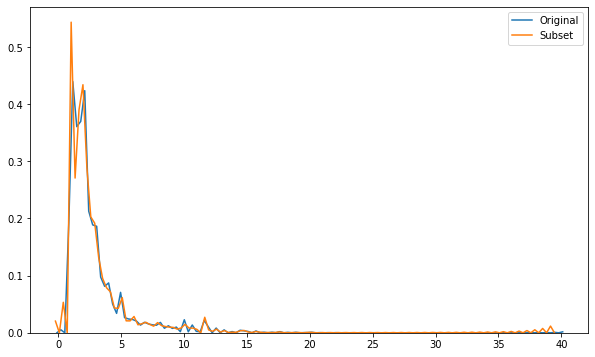

In [4]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['tip_amount'], label='Original')
sns.kdeplot(df2['tip_amount'], label='Subset')
plt.show()

##Train-test Split:

We exclude total amount, because it includes information about the tips.

In [5]:
features_lst = ['VendorID',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'fare_amount', 'extra',
       'tolls_amount', 'trip_time', 'weekday', 'pickup_hour']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df2[features_lst], df2['tip_amount'], train_size=0.7, random_state=3, shuffle=True)

## **Light Gradient Boosting Regressor**

In [10]:
gbm = lgb.LGBMRegressor(max_depth=15,n_estimators=300,random_state=1,importance_type='gain').fit(X_train, y_train)

### Feature importance

In [28]:
# Evaluation Plotting function
def plot_prediction_analysis(y, y_pred, figsize=(15,6), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='r',alpha=0.5)
    axs[0].scatter(y, y_pred, alpha=0.7, s=0.6)
    axs[0].set_xlabel('Truth')
    axs[0].set_ylabel('Prediction')
    rmse = np.sqrt(MSE(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    axs[0].set_title('RMSE = {:.2f}, MAE = {:.2f}, EVS = {:.2f}'.format(rmse, mae, evs))
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('Residuals (Truth - Prediction)')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [14]:
importances_lgb = gbm.feature_importances_
indices_lgb = np.argsort(importances_lgb)

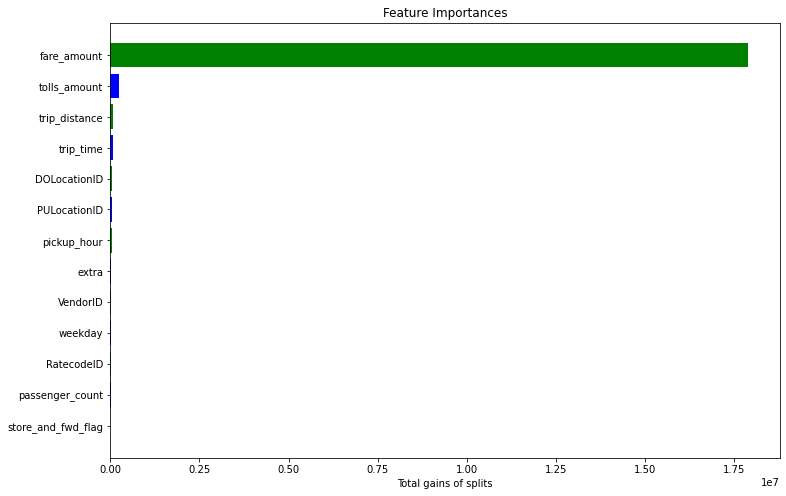

In [15]:
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices_lgb)), importances_lgb[indices_lgb], color=['g','b'], align='center')
plt.yticks(range(len(indices_lgb)), [features_lst[i] for i in indices_lgb])
plt.xlabel('Total gains of splits')
plt.show()

## Evaluation

The Median Absolute Error measures the statistical dispersion (to account for outliers).

In [31]:
train_pred_gbm = gbm.predict(X_train)
test_pred_gbm = gbm.predict(X_test)

print('R^2 of Light Gradient Boosting on training set: {:.2f}'
     .format(gbm.score(X_train, y_train)))
print('R^2 of Light Gradient Boosting on test set: {:.2f}'
     .format(gbm.score(X_test, y_test)))
print('-'*50)
print('Median Absolute Error of Light Gradient Boosting on training set: {:.2f}'
     .format(median_absolute_error(y_train, train_pred_gbm)))
print('Median Absolute Error of Light Gradient Boosting on test set: {:.2f}'
     .format(median_absolute_error(y_test, test_pred_gbm)))

R^2 of Light Gradient Boosting on training set: 0.81
R^2 of Light Gradient Boosting on test set: 0.79
--------------------------------------------------
Median Absolute Error of Light Gradient Boosting on training set: 0.26
Median Absolute Error of Light Gradient Boosting on test set: 0.26


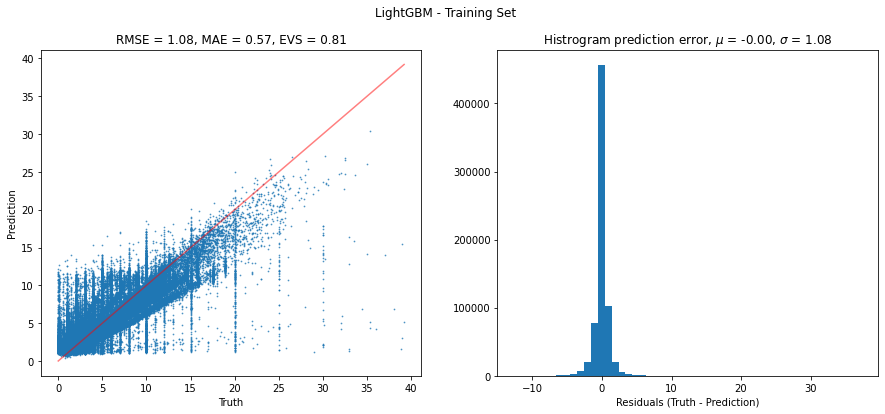

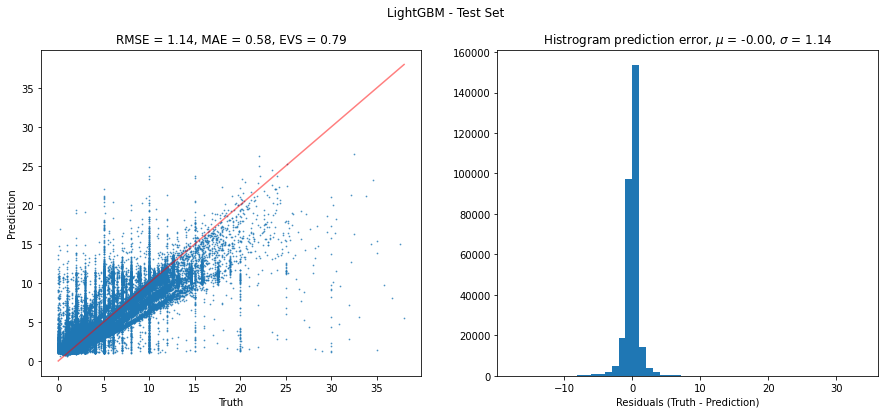

In [29]:
plot_prediction_analysis(y_train, train_pred_gbm, title='LightGBM - Training Set')
plot_prediction_analysis(y_test, test_pred_gbm, title='LightGBM - Test Set')

In [17]:
for feature in zip(features_lst, importances_lgb):
    print(feature)

('VendorID', 28345.75561928749)
('passenger_count', 11322.34974360466)
('trip_distance', 90355.74981808662)
('RatecodeID', 11775.942722558975)
('store_and_fwd_flag', 464.56995677948)
('PULocationID', 49980.22951936722)
('DOLocationID', 61250.78513288498)
('fare_amount', 17879685.362198114)
('extra', 31325.758761167526)
('tolls_amount', 247384.22411489487)
('trip_time', 72504.63157844543)
('weekday', 28215.769420862198)
('pickup_hour', 44721.62649345398)


## **Random Forest**: Grid Search with Cross Validation

We will try different combinations of settings for the hyperparameters with GridSearchCV. The more combinations, the longer it will take, so we won't make it very exhaustive.

In [18]:
param_grid = {'max_depth': [10, 15],
              'n_estimators': [100, 120], 
              'random_state': [1]} 

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3,  verbose = 2, n_jobs = -1)

In [19]:
t0 = time()
grid_fit = grid_search.fit(X_train, y_train)
print('Total Elapsed time: ', '%.3f'%(time() - t0) , 's')
print("Best Parameters Random Forest: ", grid_fit.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.5min finished


Total Elapsed time:  1035.397 s
Best Parameters Random Forest:  {'max_depth': 10, 'n_estimators': 120, 'random_state': 1}


In [20]:
results = grid_fit.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, '| Test R^2:',round(score_mean, 4), '| R^2 St. Deviation:', round(score_sd, 4))

{'max_depth': 10, 'n_estimators': 100, 'random_state': 1} | Test R^2: 0.7921 | R^2 St. Deviation: 0.0028
{'max_depth': 10, 'n_estimators': 120, 'random_state': 1} | Test R^2: 0.7922 | R^2 St. Deviation: 0.0028
{'max_depth': 15, 'n_estimators': 100, 'random_state': 1} | Test R^2: 0.7906 | R^2 St. Deviation: 0.0029
{'max_depth': 15, 'n_estimators': 120, 'random_state': 1} | Test R^2: 0.7907 | R^2 St. Deviation: 0.0029


In [21]:
best_rf = grid_fit.best_estimator_

## Evaluation

In [32]:
train_pred_rf = best_rf.predict(X_train)
test_pred_rf = best_rf.predict(X_test)

print('R^2 of Random Forest on training set: {:.2f}'
     .format(best_rf.score(X_train, y_train)))
print('R^2 of Random Forest on test set: {:.2f}'
     .format(best_rf.score(X_test, y_test)))
print('-'*50)
print('Median Absolute Error of Random Forest on training set: {:.2f}'
     .format(median_absolute_error(y_train, train_pred_rf)))
print('Median Absolute Error of Random Forest on test set: {:.2f}'
     .format(median_absolute_error(y_test, test_pred_rf)))

R^2 of Random Forest on training set: 0.81
R^2 of Random Forest on test set: 0.79
--------------------------------------------------
Median Absolute Error of Random Forest on training set: 0.25
Median Absolute Error of Random Forest on test set: 0.26


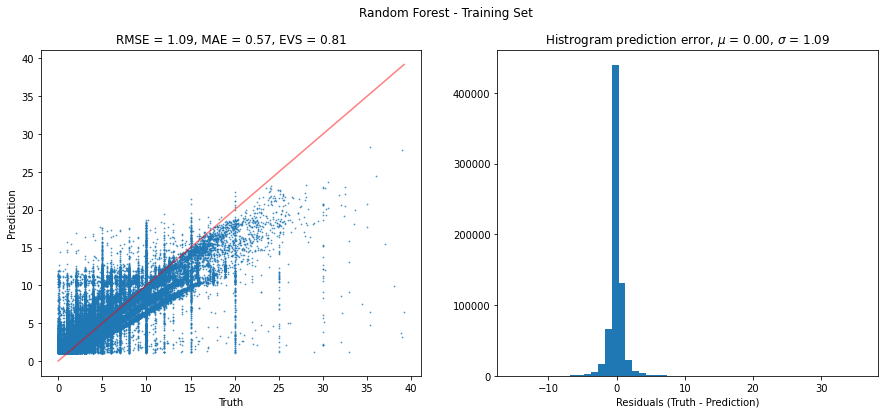

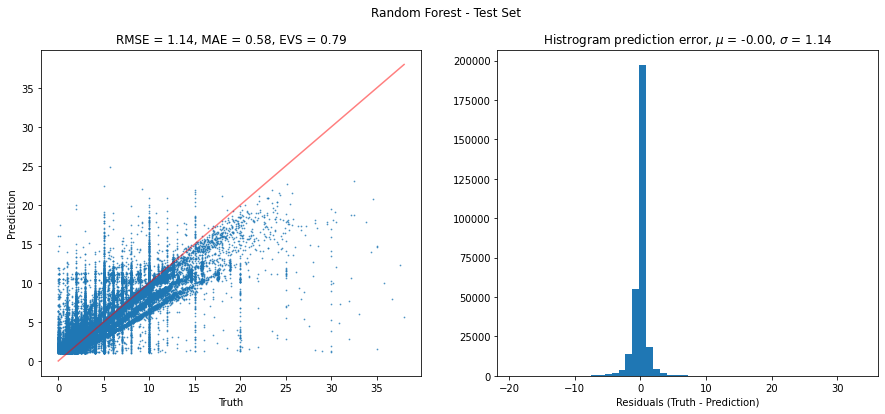

In [30]:
plot_prediction_analysis(y_train, train_pred_rf, title='Random Forest - Training Set')
plot_prediction_analysis(y_test, test_pred_rf, title='Random Forest - Test Set')

### Feature importance

In [24]:
importances_rf = best_rf.feature_importances_
indices = np.argsort(importances_rf)

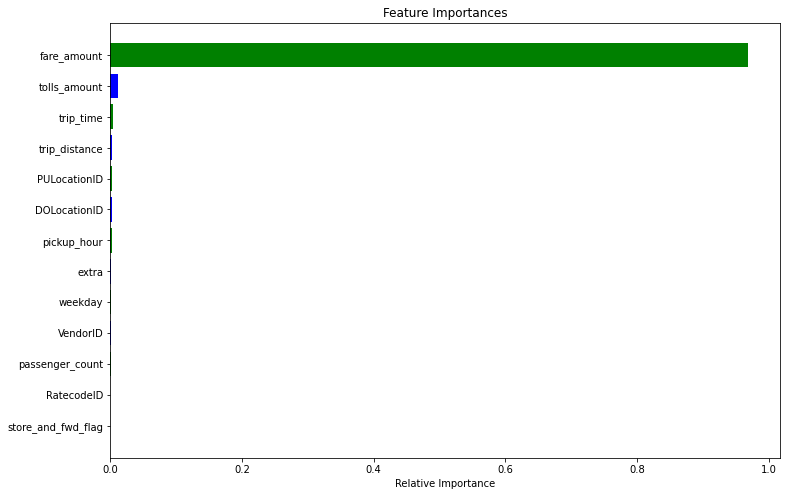

In [25]:
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color=['g','b'], align='center')
plt.yticks(range(len(indices)), [features_lst[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
for feature in zip(features_lst, importances_rf):
    print(feature)

('VendorID', 0.001190504191031157)
('passenger_count', 0.0005514507838590416)
('trip_distance', 0.0034189732046368574)
('RatecodeID', 0.0001671922697989968)
('store_and_fwd_flag', 6.490148181637321e-05)
('PULocationID', 0.0023911662992720227)
('DOLocationID', 0.0022509253913103834)
('fare_amount', 0.9679579599710857)
('extra', 0.0016918356250212104)
('tolls_amount', 0.012338946465027029)
('trip_time', 0.004559714532052945)
('weekday', 0.001375023962816877)
('pickup_hour', 0.002041405822271524)


There are some limitations of this impurity-based ranking:
- It has a bias towards variables with more categories.
- There will be a tendency to reduce the importance of some correlated variables, so it can lead to a wrong interpretation. This is an artefact of the random selection.



---

